### Packages

In [1]:
# Essentials
import pandas as pd

# ML Modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn import set_config; set_config(display='diagram')

import pickle

# For preprosessing
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

# Graphs
import matplotlib.pyplot as plt

### Data Import

In [2]:
file = '/home/nawar82/code/nawar82/ResearchTopicsRanker/raw_data/abstracts_2024-03-12_11-45-34.csv'

data = pd.read_csv(file)
data.head()

,PMID,Abstract
0,38464371,Diabetes and thyroiditis are closely related. ...
1,38449627,The thyroid represents the most prevalent form...
2,38296053,Evidence suggests that hypothyroidism may be a...
3,38287682,The aim of this study was to determine the imp...
4,38277810,"In this comprehensive study, we sought to unra..."


In [3]:
data.shape

(649, 2)

### Preprocessing

In [4]:
def preprocessing(sentence):

    # remove whitespace
    sentence = sentence.strip()

    # lowercase characters
    sentence = sentence.lower()

    # remove numbers
    sentence = ''.join(char for char in sentence if not char.isdigit())

    # remove punctuation
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '')

    # remove stop_words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    sentence = ' '.join(filtered_words)

    # tokenize and lemmatize
    words = word_tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Lemmatize verbs
    lemmatized_words = [lemmatizer.lemmatize(word, pos='n') for word in lemmatized_words]  # Lemmatize nouns

    return ' '.join(lemmatized_words)

Test data:

In [10]:
def apply_preprocessing_to_series(text_series):
    return text_series.apply(preprocessing)

In [ ]:
data['clean_text'] = data['Abstract'].apply(preprocessing)
data

### Functions

In [44]:
def lda_model_fit(n_components, max_iter, vectorized_documents):
    lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = max_iter)

    # Fit the LDA on the vectorized documents
    lda_model.fit(vectorized_documents)

    return lda_model

In [45]:
def topics_list(model, vectorizer, top_words):
    topics = []
    for idx, topic in enumerate(model.components_):
        # print("Topic %d:" % (idx))
        topic = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_words - 1:-1]]
        # print(topic)
        topics.append(topic)
    return topics

In [46]:
def print_topics(model, vectorizer):
    topics = []
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        topic = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-10 - 1:-1]]
        print(topic)
        topics.append(topic)
    return topics

In [47]:
def graph_topics(topics):
    # Calculating the number of rows and columns
    num_sets = len(topics)
    num_cols = 2  # Number of columns you want
    num_rows = -(-num_sets // num_cols)  # Ceiling division to ensure enough rows

    # Plotting each data set
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    for i, data in enumerate(topics):
        row = i // num_cols
        col = i % num_cols
        labels = [item[0] for item in data]
        values = [item[1] for item in data]
        axs[row, col].barh(labels, values, color='skyblue')
        axs[row, col].set_ylabel('Keywords')
        axs[row, col].set_title('Topic {}'.format(i))
        axs[row, col].invert_yaxis()

    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

### Run LDA to see the topics

In [ ]:
vectorizer = TfidfVectorizer(max_df = 0.60, ngram_range=(2,3))

vectorized_documents = vectorizer.fit_transform(data['clean_text'])

In [ ]:
vectorized_documents.shape

In [ ]:
# Instantiate the LDA
n_components = 10
lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = 500)

# Fit the LDA on the vectorized documents
lda_model.fit(vectorized_documents)

In [11]:
clean = FunctionTransformer(apply_preprocessing_to_series)

#clean = FunctionTransformer(lambda data: data['Abstract'].apply(preprocessing))
clean

FunctionTransformer(func=<function apply_preprocessing_to_series at 0x7f1474f71630>)

In [12]:
preproc = Pipeline([
    ('cleaning', clean),
    ('vectorize', TfidfVectorizer(max_df = 0.60, ngram_range=(2,3)))
])
preproc

Pipeline(steps=[('cleaning',
                 FunctionTransformer(func=<function apply_preprocessing_to_series at 0x7f1474f71630>)),
                ('vectorize', TfidfVectorizer(max_df=0.6, ngram_range=(2, 3)))])

In [13]:
pipe = make_pipeline(preproc, LatentDirichletAllocation(n_components=10, max_iter = 500))
pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('cleaning',
                                  FunctionTransformer(func=<function apply_preprocessing_to_series at 0x7f1474f71630>)),
                                 ('vectorize',
                                  TfidfVectorizer(max_df=0.6,
                                                  ngram_range=(2, 3)))])),
                ('latentdirichletallocation',
                 LatentDirichletAllocation(max_iter=500))])

In [14]:
# # Export the fitted pipeline as a pickle file
with open('../models/lda_model.pkl', 'wb') as file:
    pickle.dump(pipe, file)

print("Pipeline is successfully saved as 'lda_model.pkl'")


Pipeline is successfully saved as 'lda_model.pkl'


In [15]:
pipe.fit(data['Abstract'])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('cleaning',
                                  FunctionTransformer(func=<function apply_preprocessing_to_series at 0x7f1474f71630>)),
                                 ('vectorize',
                                  TfidfVectorizer(max_df=0.6,
                                                  ngram_range=(2, 3)))])),
                ('latentdirichletallocation',
                 LatentDirichletAllocation(max_iter=500))])

In [18]:
document_topic_mixture = pd.DataFrame(pipe.transform(data['Abstract']),
                                      columns = [f"topic_{i}" for i in range(1, 11)],
                                      index = data['PMID'])
document_topic_mixture

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
PMID,,,,,,,,,,
38464371,0.005393,0.005393,0.951463,0.005393,0.005393,0.005393,0.005393,0.005393,0.005393,0.005393
38449627,0.945173,0.006092,0.006092,0.006092,0.006092,0.006092,0.006092,0.006092,0.006092,0.006092
38296053,0.949346,0.005629,0.005628,0.005628,0.005628,0.005628,0.005628,0.005628,0.005628,0.005629
38287682,0.006289,0.006289,0.943402,0.006289,0.006289,0.006289,0.006289,0.006289,0.006289,0.006289
38277810,0.006526,0.006526,0.006526,0.006526,0.006526,0.006526,0.006526,0.006526,0.941269,0.006526
...,...,...,...,...,...,...,...,...,...,...
6127000,0.007677,0.007676,0.007677,0.930912,0.007676,0.007676,0.007676,0.007676,0.007676,0.007676
7288274,0.007223,0.007223,0.007223,0.934993,0.007224,0.007223,0.007223,0.007223,0.007223,0.007223
6794011,0.008312,0.008312,0.008312,0.008312,0.008312,0.008312,0.008312,0.008312,0.008312,0.925188


In [41]:
pipe.named_steps['pipeline']['vectorize'].get_feature_names_out()

array(['aa addition', 'aa addition fatty', 'aa adrenic', ...,
       'μuml subclinical hypothyroidism', 'μuml synergized',
       'μuml synergized increase'], dtype=object)

In [42]:
topic_word_mixture = pd.DataFrame(
    pipe.named_steps['latentdirichletallocation'].components_,
    columns = pipe.named_steps['pipeline']['vectorize'].get_feature_names_out(),
    index = document_topic_mixture.columns
)
topic_word_mixture

,aa addition,aa addition fatty,aa adrenic,aa adrenic acid,aa class,aa class pgl,aa deficit,aa deficit hormone,aa depletion,aa depletion diversely,...,μuml euthyroid,μuml euthyroid state,μuml ngdl,μuml ngdl respectively,μuml patient,μuml patient overt,μuml subclinical,μuml subclinical hypothyroidism,μuml synergized,μuml synergized increase
topic_1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.168451,0.168451,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_2,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.153179,0.153179
topic_3,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_5,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_6,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_7,0.146579,0.146579,0.193158,0.193158,0.146579,0.146579,0.146579,0.146579,0.146579,0.146579,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_8,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_9,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.153764,0.153764,0.100000,0.100000,0.153764,0.153764,0.153764,0.153764,0.100000,0.100000
topic_10,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


In [48]:
topics = topics_list(pipe.named_steps['latentdirichletallocation'], pipe.named_steps['pipeline']['vectorize'], 10)

In [49]:
type(topics)

list

In [50]:
type(topics[0])

list

In [51]:
type(topics[0][0])

tuple

In [52]:
topics[1][0]

('tsh level', 0.8338142641655191)

In [53]:
len(topics)

10

In [54]:
topics

[[('tsh level', 0.7474447559790404),
  ('total cholesterol', 0.733947434640872),
  ('thyroid function', 0.6941757553017764),
  ('thyroid hormone', 0.6645760762509563),
  ('risk factor', 0.6473424246405888),
  ('leydig cell', 0.607715279758135),
  ('lipoprotein cholesterol', 0.5929931797311175),
  ('hdlcapoai ratio', 0.5611423841817568),
  ('cf patient', 0.5519059618647711),
  ('lowdensity lipoprotein', 0.5401293842023297)],
 [('tsh level', 0.8338142641655191),
  ('thyroid hormone', 0.7522552187553626),
  ('per cent', 0.6724992684425111),
  ('thyroid function', 0.6136271730693125),
  ('ldl cholesterol', 0.5870425724581957),
  ('serum level', 0.5328953735662558),
  ('subclinical hypothyroidism', 0.5318236921310078),
  ('total cholesterol', 0.5281031432665898),
  ('onset narcolepsy', 0.5211685532673909),
  ('lipid profile', 0.5210506782797738)],
 [('thyroid hormone', 0.9496180536120181),
  ('thyroid function', 0.9233435382009566),
  ('tsh level', 0.8491096772834008),
  ('lipoprotein chole

In [56]:
pipe.named_steps['latentdirichletallocation'].components_.shape

(10, 149271)

In [57]:
pipe.named_steps['pipeline']['vectorize'].get_feature_names_out().shape

(149271,)

In [58]:
pipe.named_steps['latentdirichletallocation'].components_[1].sum()

15931.057457082043

### Visualization

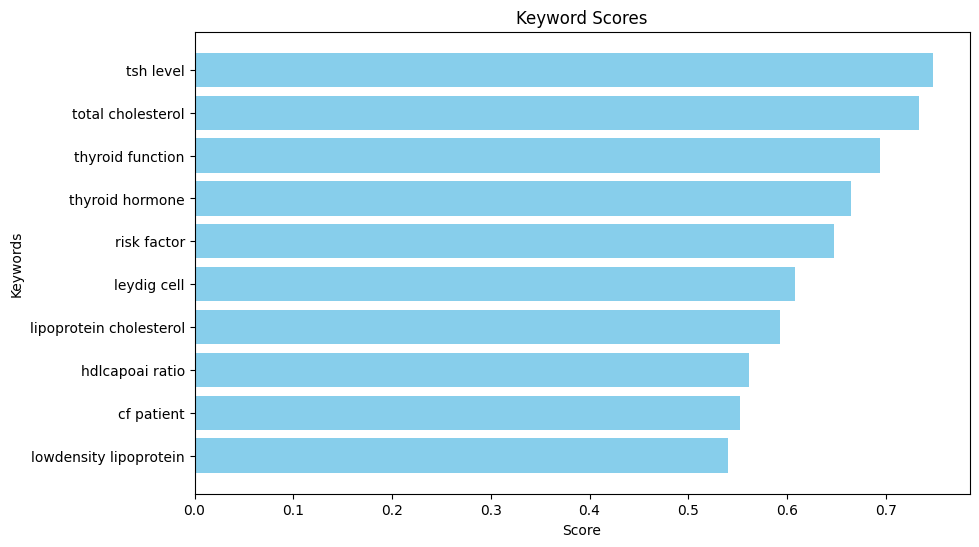

In [59]:
data = topics[0]

labels = [item[0] for item in data]
values = [item[1] for item in data]

# Creating bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Score')
plt.ylabel('Keywords')
plt.title('Keyword Scores')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

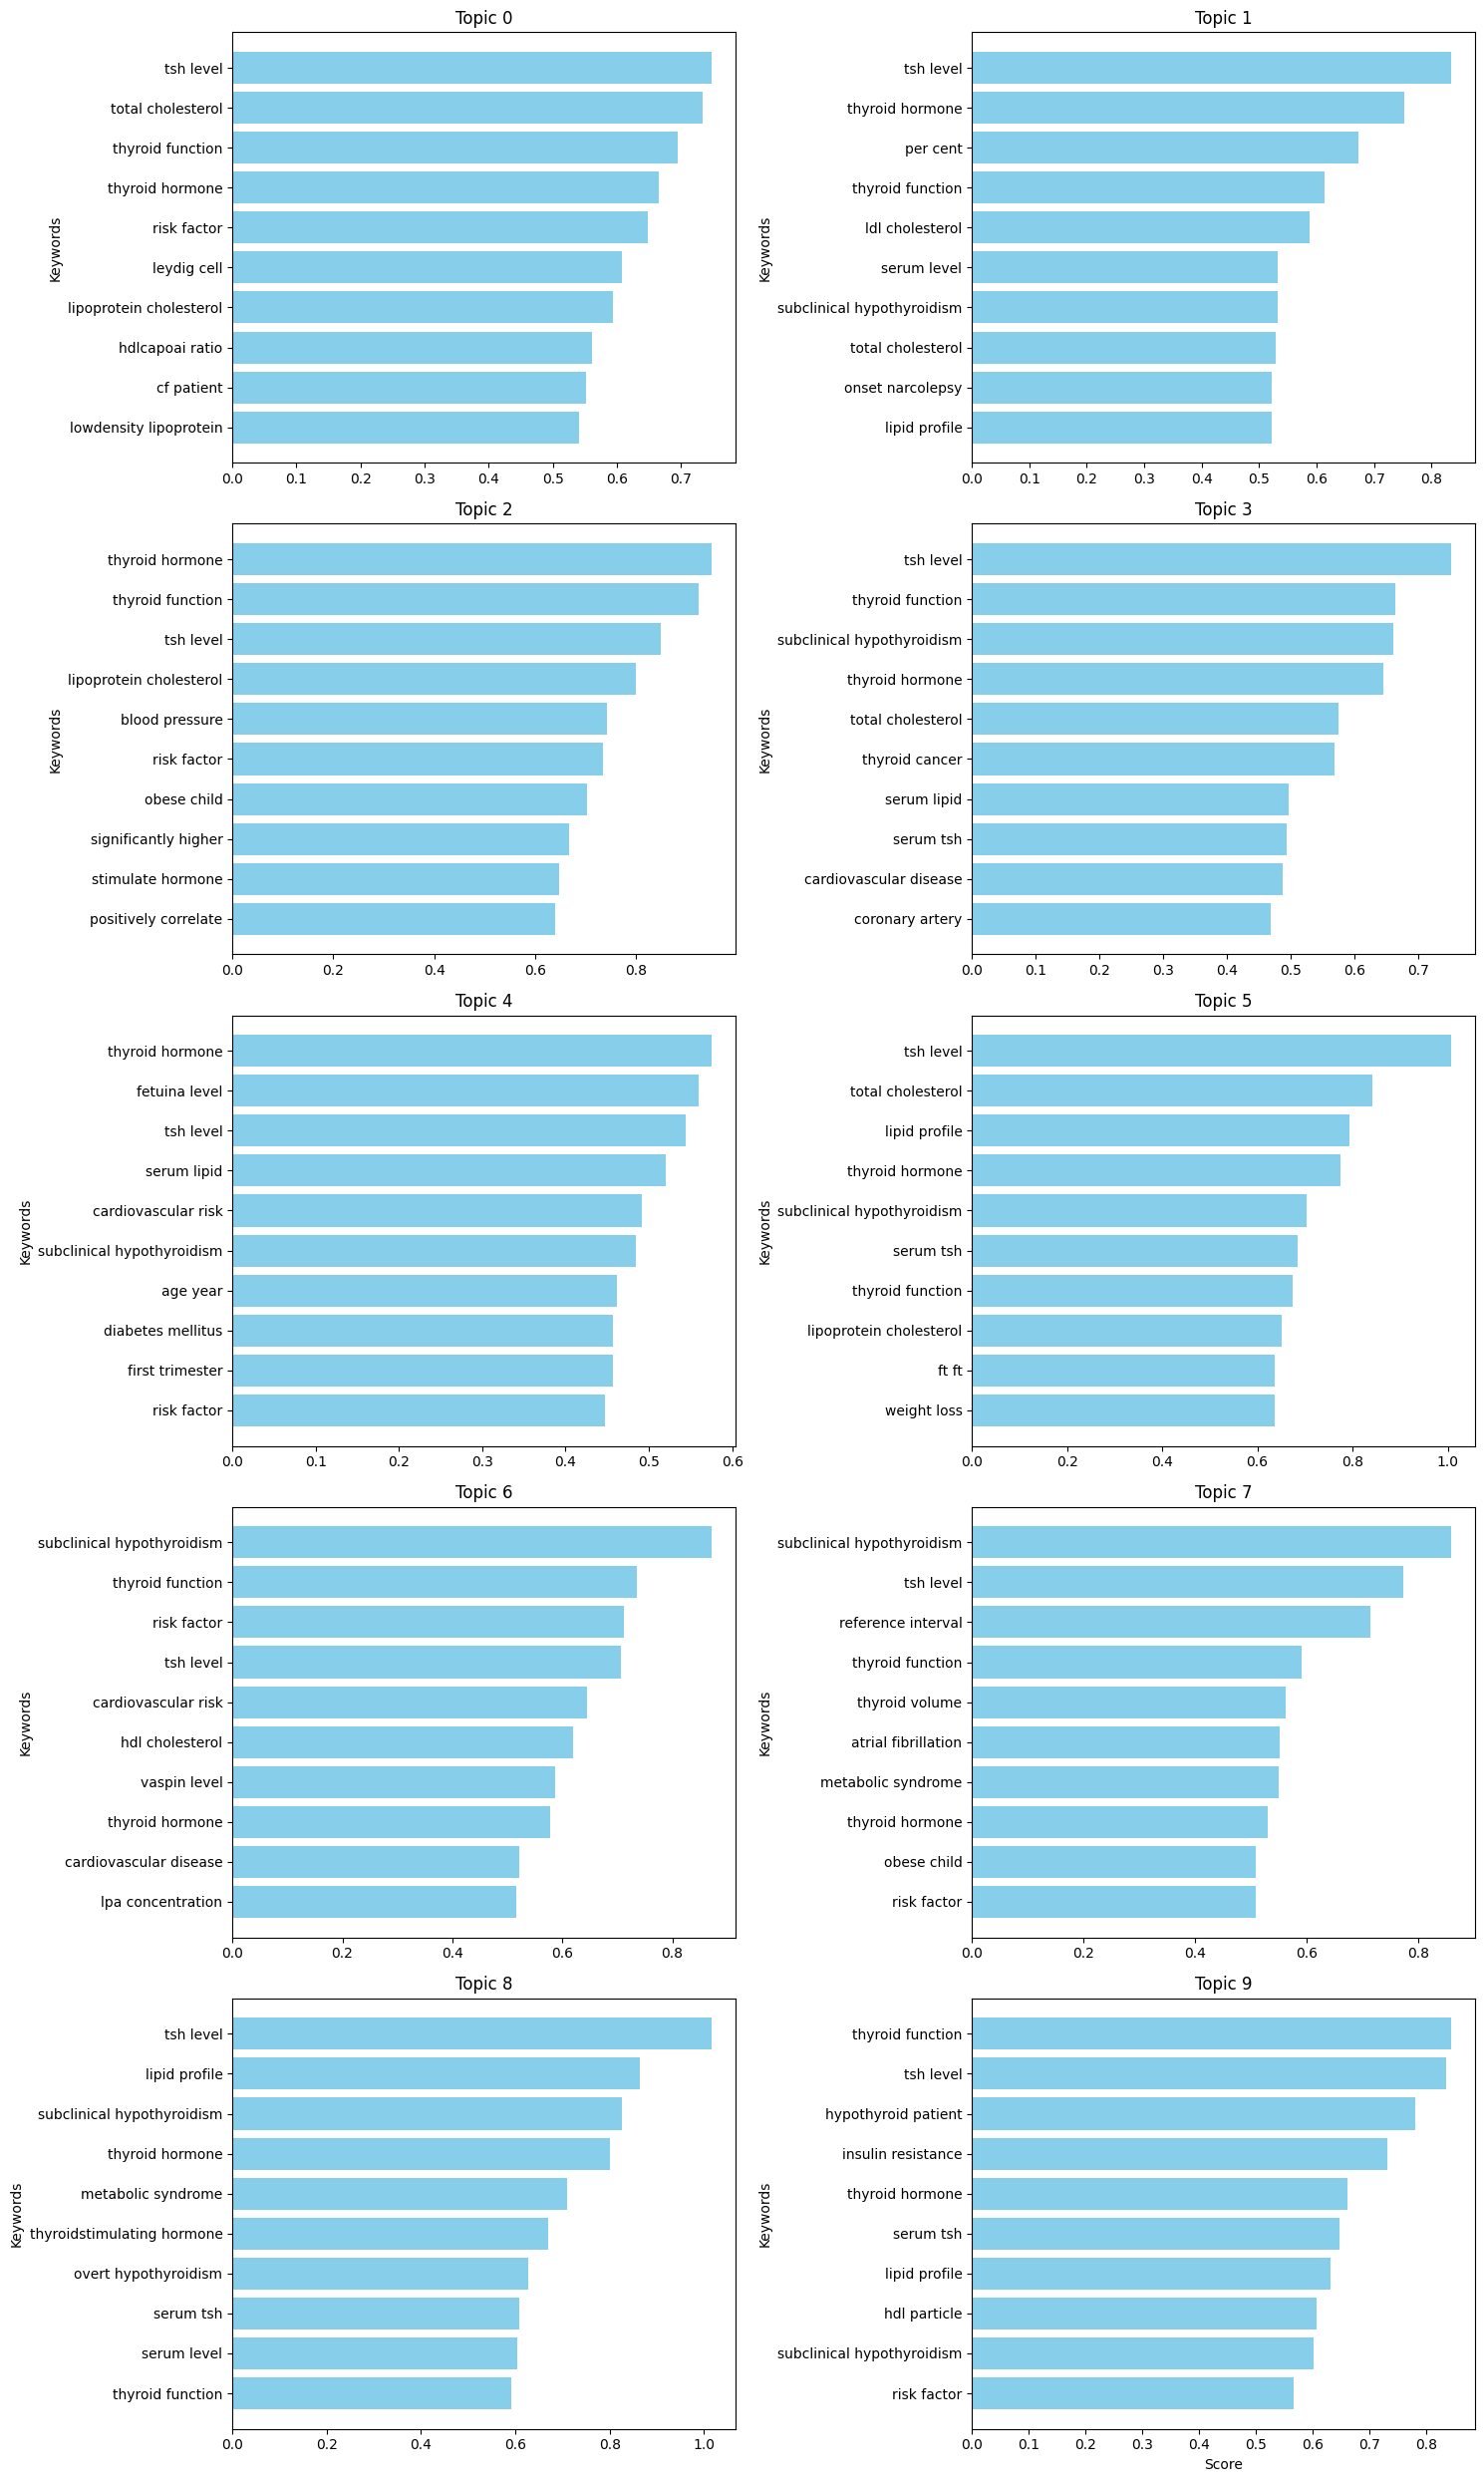

In [60]:
graph_topics(topics)